In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt

from loader import All_fundus_files
from networks import weights_init, Discriminator_128_v2, Flatten

dataroot = "data/fundus2/"
batch_size = 64
image_size = 128 #size using data aug.
num_classes = 5

ch_out = 3 
#ch_noise = 100
#ch_g = 64
ch_d = 64

num_epochs = 500
lr = 0.0002
beta1 = 0.5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
    cudnn.benchmark = True

cuda


In [3]:
# Data
transform_train = transforms.Compose([
    #transforms.RandomResizedCrop(image_size),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.ImageFolder(root=dataroot+'sorted', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

testset = torchvision.datasets.ImageFolder(root=dataroot+'val', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

classes = testset.classes
print(trainset.classes)
print(testset.class_to_idx)
print(len(trainset), len(testset))

['catergory00', 'catergory01', 'catergory02', 'catergory03', 'catergory04']
{'catergory00': 0, 'catergory01': 1, 'catergory02': 2, 'catergory03': 3, 'catergory04': 4}
3462 200


In [4]:
# Model
net = Discriminator_128_v2(ch_out, ch_d)
net.backbone[14] = nn.AdaptiveAvgPool2d((1, 1)) 
net.backbone[15] = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=ch_d * 16, out_features=num_classes, bias=True)
)
net = net.to(device)
net.apply(weights_init)
print(net)

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if True:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/exp4/ckpt.pth')
    msg = net.load_state_dict(checkpoint['net'], strict=False)
    assert set(msg.missing_keys) == {"backbone.15.1.weight", "backbone.15.1.bias"}, 'missing_keys: {}'.format(set(msg.missing_keys))
    assert set(msg.unexpected_keys) == {"backbone.14.weight"}, 'unexpected_keys: {}'.format(set(msg.unexpected_keys))
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    print(best_acc,start_epoch)
    
    for name, param in net.named_parameters():
        if name not in ["backbone.11.weight", "backbone.12.weight", "backbone.12.bias", "backbone.15.1.weight", "backbone.15.1.bias"]:
            param.requires_grad = False
        else:
            print('{}'.format(name))
    '''
    backbone.0.weight
    backbone.2.weight
    backbone.3.weight
    backbone.3.bias
    backbone.5.weight
    backbone.6.weight
    backbone.6.bias
    backbone.8.weight
    backbone.9.weight
    backbone.9.bias
    backbone.11.weight
    backbone.12.weight
    backbone.12.bias
    backbone.15.1.weight
    backbone.15.1.bias
    '''
    # check
    parameters = list(filter(lambda p: p.requires_grad, net.parameters()))
    assert len(parameters) == 5


# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, lr=lr, betas=(beta1, 0.999))
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [100,250], gamma=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


Discriminator_128_v2(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024

In [5]:
from torchsummary import summary
summary(net, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-10            [-1, 512, 8, 8]           1,024
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 4, 4]       8,388,608
      BatchNorm2d-13           [-1, 1024, 4, 4]           2,048
        LeakyReLU-14           [-1, 102

In [6]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train Loss: %.3f | Acc: %.3f%% (%d/%d)' %(train_loss / (batch_idx+1), 100.*correct/total, correct, total))
    return train_loss /(batch_idx+1), correct/total

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print('Test Loss: %.3f | Acc: %.3f%% (%d/%d)' %(test_loss /(batch_idx+1), 100.*correct/total, correct, total))
    return test_loss /(batch_idx+1), correct/total

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint/exp3'):
            os.mkdir('checkpoint/exp3')
        torch.save(state, './checkpoint/exp3/ckpt.pth')
        best_acc = acc

Train_losses = []
Test_losses = []
Train_acc = []
Test_acc = []
for epoch in range(start_epoch, start_epoch+num_epochs):
    ls, acc = train(epoch)
    Train_losses.append(ls)
    Train_acc.append(acc)
    
    ls, acc = test(epoch)
    Test_losses.append(ls)
    Test_acc.append(acc)
    
    scheduler.step()


Epoch: 50
Train Loss: 0.846 | Acc: 70.508% (2441/3462)
Test Loss: 1.809 | Acc: 40.000% (80/200)

Epoch: 51
Train Loss: 0.747 | Acc: 72.819% (2521/3462)
Test Loss: 1.612 | Acc: 47.500% (95/200)

Epoch: 52
Train Loss: 0.719 | Acc: 74.206% (2569/3462)
Test Loss: 1.442 | Acc: 48.000% (96/200)

Epoch: 53
Train Loss: 0.707 | Acc: 74.957% (2595/3462)
Test Loss: 1.540 | Acc: 46.500% (93/200)

Epoch: 54
Train Loss: 0.693 | Acc: 74.841% (2591/3462)
Test Loss: 1.425 | Acc: 46.000% (92/200)

Epoch: 55
Train Loss: 0.695 | Acc: 75.881% (2627/3462)
Test Loss: 1.564 | Acc: 45.500% (91/200)

Epoch: 56
Train Loss: 0.656 | Acc: 76.228% (2639/3462)
Test Loss: 1.390 | Acc: 47.500% (95/200)

Epoch: 57
Train Loss: 0.644 | Acc: 76.372% (2644/3462)
Test Loss: 1.509 | Acc: 42.000% (84/200)

Epoch: 58
Train Loss: 0.654 | Acc: 75.881% (2627/3462)
Test Loss: 1.295 | Acc: 50.000% (100/200)

Epoch: 59
Train Loss: 0.654 | Acc: 76.372% (2644/3462)
Test Loss: 1.463 | Acc: 45.500% (91/200)

Epoch: 60
Train Loss: 0.644 

Train Loss: 0.417 | Acc: 84.460% (2924/3462)
Test Loss: 1.319 | Acc: 51.500% (103/200)

Epoch: 135
Train Loss: 0.419 | Acc: 84.344% (2920/3462)
Test Loss: 1.468 | Acc: 53.000% (106/200)

Epoch: 136
Train Loss: 0.411 | Acc: 83.911% (2905/3462)
Test Loss: 1.244 | Acc: 57.000% (114/200)

Epoch: 137
Train Loss: 0.411 | Acc: 85.240% (2951/3462)
Test Loss: 1.524 | Acc: 54.000% (108/200)

Epoch: 138
Train Loss: 0.424 | Acc: 84.431% (2923/3462)
Test Loss: 2.279 | Acc: 47.000% (94/200)

Epoch: 139
Train Loss: 0.429 | Acc: 83.767% (2900/3462)
Test Loss: 1.459 | Acc: 56.500% (113/200)

Epoch: 140
Train Loss: 0.402 | Acc: 84.258% (2917/3462)
Test Loss: 1.206 | Acc: 54.000% (108/200)

Epoch: 141
Train Loss: 0.408 | Acc: 84.055% (2910/3462)
Test Loss: 1.366 | Acc: 56.000% (112/200)

Epoch: 142
Train Loss: 0.406 | Acc: 84.662% (2931/3462)
Test Loss: 1.405 | Acc: 54.500% (109/200)

Epoch: 143
Train Loss: 0.402 | Acc: 84.951% (2941/3462)
Test Loss: 1.605 | Acc: 55.000% (110/200)

Epoch: 144
Train Loss:

Train Loss: 0.281 | Acc: 89.544% (3100/3462)
Test Loss: 2.125 | Acc: 53.000% (106/200)

Epoch: 218
Train Loss: 0.294 | Acc: 88.966% (3080/3462)
Test Loss: 1.567 | Acc: 53.500% (107/200)

Epoch: 219
Train Loss: 0.260 | Acc: 90.757% (3142/3462)
Test Loss: 1.684 | Acc: 56.500% (113/200)

Epoch: 220
Train Loss: 0.286 | Acc: 90.121% (3120/3462)
Test Loss: 1.981 | Acc: 52.000% (104/200)

Epoch: 221
Train Loss: 0.289 | Acc: 89.313% (3092/3462)
Test Loss: 1.616 | Acc: 57.000% (114/200)

Epoch: 222
Train Loss: 0.256 | Acc: 90.757% (3142/3462)
Test Loss: 1.823 | Acc: 58.500% (117/200)

Epoch: 223
Train Loss: 0.303 | Acc: 89.284% (3091/3462)
Test Loss: 2.220 | Acc: 53.000% (106/200)

Epoch: 224
Train Loss: 0.278 | Acc: 90.583% (3136/3462)
Test Loss: 2.011 | Acc: 58.000% (116/200)

Epoch: 225
Train Loss: 0.274 | Acc: 89.573% (3101/3462)
Test Loss: 1.676 | Acc: 52.000% (104/200)

Epoch: 226
Train Loss: 0.253 | Acc: 90.295% (3126/3462)
Test Loss: 1.563 | Acc: 57.000% (114/200)

Epoch: 227
Train Loss

Train Loss: 0.176 | Acc: 93.819% (3248/3462)
Test Loss: 1.852 | Acc: 57.000% (114/200)

Epoch: 301
Train Loss: 0.181 | Acc: 94.021% (3255/3462)
Test Loss: 2.173 | Acc: 57.500% (115/200)

Epoch: 302
Train Loss: 0.184 | Acc: 93.819% (3248/3462)
Test Loss: 2.150 | Acc: 57.500% (115/200)

Epoch: 303
Train Loss: 0.172 | Acc: 93.645% (3242/3462)
Test Loss: 1.996 | Acc: 54.500% (109/200)

Epoch: 304
Train Loss: 0.187 | Acc: 93.154% (3225/3462)
Test Loss: 1.787 | Acc: 59.000% (118/200)

Epoch: 305
Train Loss: 0.177 | Acc: 94.512% (3272/3462)
Test Loss: 3.281 | Acc: 41.500% (83/200)

Epoch: 306
Train Loss: 0.198 | Acc: 93.270% (3229/3462)
Test Loss: 1.856 | Acc: 58.000% (116/200)

Epoch: 307
Train Loss: 0.185 | Acc: 93.790% (3247/3462)
Test Loss: 1.966 | Acc: 58.000% (116/200)

Epoch: 308
Train Loss: 0.180 | Acc: 93.414% (3234/3462)
Test Loss: 1.941 | Acc: 56.500% (113/200)

Epoch: 309
Train Loss: 0.177 | Acc: 93.328% (3231/3462)
Test Loss: 1.894 | Acc: 54.500% (109/200)

Epoch: 310
Train Loss:

Train Loss: 0.125 | Acc: 95.841% (3318/3462)
Test Loss: 1.994 | Acc: 60.000% (120/200)

Epoch: 384
Train Loss: 0.131 | Acc: 95.754% (3315/3462)
Test Loss: 1.904 | Acc: 58.500% (117/200)

Epoch: 385
Train Loss: 0.127 | Acc: 95.754% (3315/3462)
Test Loss: 1.935 | Acc: 58.500% (117/200)

Epoch: 386
Train Loss: 0.124 | Acc: 95.956% (3322/3462)
Test Loss: 2.029 | Acc: 60.500% (121/200)

Epoch: 387
Train Loss: 0.125 | Acc: 95.898% (3320/3462)
Test Loss: 2.317 | Acc: 59.500% (119/200)

Epoch: 388
Train Loss: 0.144 | Acc: 96.158% (3329/3462)
Test Loss: 2.118 | Acc: 58.500% (117/200)

Epoch: 389
Train Loss: 0.126 | Acc: 95.869% (3319/3462)
Test Loss: 2.177 | Acc: 58.000% (116/200)

Epoch: 390
Train Loss: 0.149 | Acc: 95.552% (3308/3462)
Test Loss: 2.138 | Acc: 60.000% (120/200)

Epoch: 391
Train Loss: 0.123 | Acc: 96.129% (3328/3462)
Test Loss: 2.089 | Acc: 57.000% (114/200)

Epoch: 392
Train Loss: 0.119 | Acc: 96.303% (3334/3462)
Test Loss: 2.184 | Acc: 59.000% (118/200)

Epoch: 393
Train Loss

Train Loss: 0.095 | Acc: 97.256% (3367/3462)
Test Loss: 2.168 | Acc: 59.000% (118/200)

Epoch: 467
Train Loss: 0.096 | Acc: 97.198% (3365/3462)
Test Loss: 2.208 | Acc: 60.000% (120/200)

Epoch: 468
Train Loss: 0.093 | Acc: 97.140% (3363/3462)
Test Loss: 2.254 | Acc: 57.500% (115/200)

Epoch: 469
Train Loss: 0.161 | Acc: 97.400% (3372/3462)
Test Loss: 2.370 | Acc: 61.000% (122/200)

Epoch: 470
Train Loss: 0.097 | Acc: 97.343% (3370/3462)
Test Loss: 2.205 | Acc: 60.500% (121/200)

Epoch: 471
Train Loss: 0.097 | Acc: 97.603% (3379/3462)
Test Loss: 2.165 | Acc: 60.000% (120/200)

Epoch: 472
Train Loss: 0.100 | Acc: 97.487% (3375/3462)
Test Loss: 2.139 | Acc: 60.000% (120/200)

Epoch: 473
Train Loss: 0.099 | Acc: 96.880% (3354/3462)
Test Loss: 2.267 | Acc: 59.500% (119/200)

Epoch: 474
Train Loss: 0.098 | Acc: 97.169% (3364/3462)
Test Loss: 2.097 | Acc: 58.000% (116/200)

Epoch: 475
Train Loss: 0.091 | Acc: 97.574% (3378/3462)
Test Loss: 2.220 | Acc: 59.500% (119/200)

Epoch: 476
Train Loss

Train Loss: 0.098 | Acc: 97.314% (3369/3462)
Test Loss: 2.216 | Acc: 60.500% (121/200)


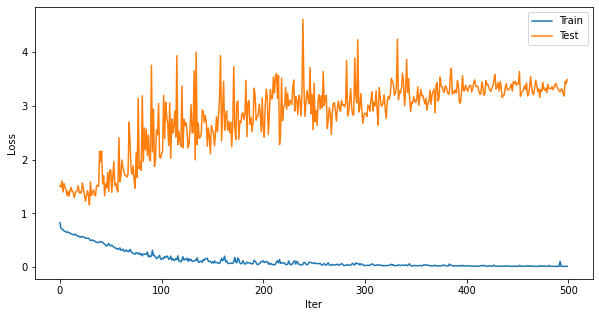

In [7]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(Train_losses,label="Train")
plt.plot(Test_losses,label="Test")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

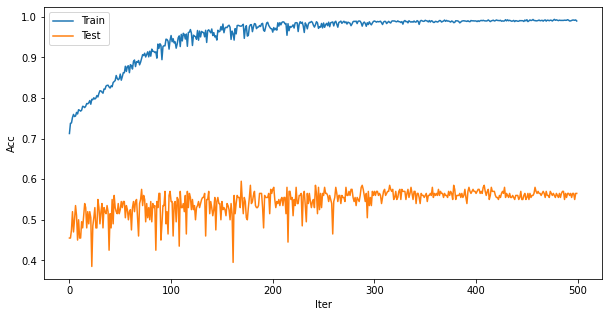

In [8]:
# check acc
plt.figure(figsize=(10,5))
plt.plot(Train_acc,label="Train")
plt.plot(Test_acc,label="Test")
plt.xlabel("Iter")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [9]:
def test_only():
    net.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))
    return (100 * correct / total)

acc = test_only() 

Accuracy of the network on the 10000 test images: 56.500000 %


In [10]:
def test_each_class():
    net.eval()
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    #label = int(label.cpu().numpy())
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.2f} %".format(classname,
        accuracy))

test_each_class()

Accuracy for class catergory00 is: 97.50 %
Accuracy for class catergory01 is: 55.00 %
Accuracy for class catergory02 is: 80.00 %
Accuracy for class catergory03 is: 30.00 %
Accuracy for class catergory04 is: 20.00 %


In [ ]:
# save
state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
#torch.save(state, './checkpoint/ckpt_fin.pth')

In [ ]:
# load
resume = 'ckpt'
checkpoint = torch.load('./checkpoint/'+resume+'.pth')
#net.load_state_dict(checkpoint['net'])

In [ ]:
acc = test_only() 
test_each_class()